In [1]:
%matplotlib inline

In [2]:
# installed via pip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from pyriemann.classification import MDM
from pyriemann.utils.distance import distance_riemann 
from tqdm import tqdm
from collections import OrderedDict

# get the functions from RPA package
import rpa.transfer_learning as TL
import rpa.diffusion_map as DM
import rpa.get_dataset as GD

# Example with Motor Imagery dataset

This is an example with data from the GigaDB dataset, which is publicly available at http://gigadb.org/dataset/100295

The original dataset contains recordings from experiments on 52 subjects performing **motor imagery** tasks for two classes and with 64 electrodes. The experiments consisted of 5 runs with 40 trials, making a total of 200 trials in the dataset (100 for each class). We included in the ```/datasets``` folder of this repository the data from subjects 1, 26, and 43 (here they are called subjects 1, 2, and 3, respectively).

We followed the **classic preprocessing pipeline** for BCI signals in motor imagery, applyinh a 8-35 Hz bandpass filter to the signals and then taking epochs of 2 seconds for each experimental trial. We downsampled the electrodes to 22 channels, discarding the electrodes from regions that we knew were not physiologically relevant for the cognitive task performed in this experiment. Finally, we estimated the spatial covariance matrices for each of the trials and stored them in a pickle file accessible from the ```/datasets``` folder.

Our goal in this example was to show the importance of matching the statistical distributions of datasets when doing Transfer Learning. We used our method Riemannian Procrustes Analysis (RPA) for matching the data points and then trained a classifier in a *source* dataset and used it on a *target* dataset. 

In [3]:
# get the dataset
datafolder = '../datasets/'
paradigm = 'motorimagery'
target = GD.get_dataset(datafolder, paradigm, subject=1) 
source = GD.get_dataset(datafolder, paradigm, subject=2)

### Spectral embedding of the datasets before RPA

We start our analysis by first using the manifold learning algorithm explained in [1] to come up with a visual representation of the data points in the *source* and *target* datasets. We use the **geodesic distance in the SPD manifold** to measure distances between the covariance matrices in the datasets.

[1] P. L. C. Rodrigues et al., *“Multivariate time-series analysis via manifold learning”*, in 2018 IEEE Statistical Signal Processing Workshop (SSP), 2018.

In [4]:
# get the diffusion maps embedding for the matrices before RPA
covs = np.concatenate([source['covs'], target['covs']])
labs = np.concatenate([source['labels'], target['labels']])
sess = np.array([1]*len(source['covs']) + [2]*len(target['covs']))
uorg,l = DM.get_diffusionEmbedding(points=covs, distance=distance_riemann) 

We make a scatter plot for the first two axis of the spectral embedding via diffusion maps. Both figures are the same, we only change the color scheme : in the left plot the colors are determined by which session the data point comes from (*source* or *target*), whereas the right plot gives colors in terms of the classes of the data points. Note that the left plot gives **two very well defined clusters** in terms of the recordings sessions, a consequence of the clear difference in the statistics of the data points from each set. We note that the right plot does not separate well the points of each class, but this is a normal result, since the main source of difference between the data points comes from the session to which they belong to, so the differences in classes get masked.

From the results below we conlude that something has to be done with the data points before using a classifier trained on one dataset to infer labels from another dataset. On the next session we will use RPA for matching the statistics of the data points from each session.

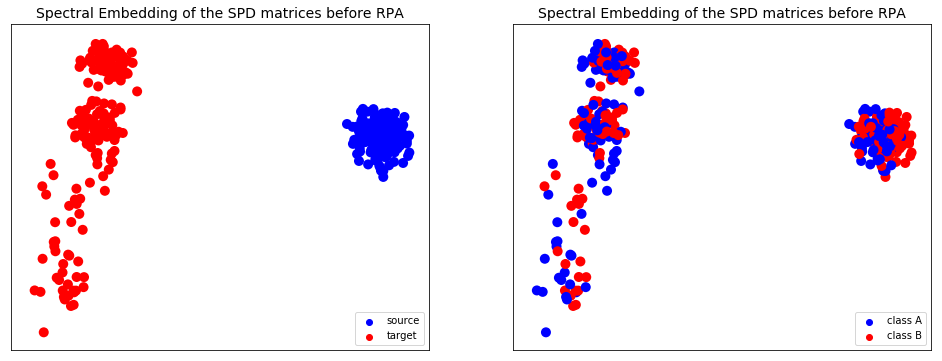

In [5]:
# plot the scatter plot for the spectral embedding
fig, ax = plt.subplots(facecolor='white', figsize=(16.5,6), ncols=2)
colors = {1:'b', 2:'r', 3:'g'}

for ui, si in zip(uorg, sess):
    ax[0].scatter(ui[1], ui[2], s=100, facecolor=colors[si], edgecolor='none')
ax[0].set_title('Spectral Embedding of the SPD matrices before RPA', fontsize=14)   
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].scatter([], [], facecolor=colors[1], label='source')
ax[0].scatter([], [], facecolor=colors[2], label='target')
ax[0].legend(loc='lower right')

for ui, yi in zip(uorg, labs):
    ax[1].scatter(ui[1], ui[2], s=100, facecolor=colors[yi], edgecolor='none')
ax[1].set_title('Spectral Embedding of the SPD matrices before RPA', fontsize=14)   
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].scatter([], [], facecolor=colors[1], label='class A')
ax[1].scatter([], [], facecolor=colors[2], label='class B')
ax[1].legend(loc='lower right')

### Classification performance

We now investigate how the matching of statistical distributions via RPA improves the classification of the data points. As explained in our paper, the *target* dataset $\mathcal{T}$ is considered to be **partitioned** in two subsets: $\mathcal{T}_{\ell}$ whose labels are known, and $\mathcal{T}_{u}$ whose labels are unknown. Since the scores of classification may vary for each partition of the *target* dataset, we do ten splits of it and consider the average score as our final results. The *source* dataset is denoted $\mathcal{S}$.

On all classification tasks, we train a MDM classifier (see [2] for details) on a dataset $\mathcal{D}_{\text{train}}$ and apply it to a test dataset $\mathcal{D}_{\text{test}}$. 

We consider four different methods:

- **org** : no distribution matching is done, so we have that 

$$\mathcal{D}_{\text{train}} = \mathcal{S} \cup \mathcal{T}_{\text{train}} \quad \text{ and } \quad \mathcal{D}_{\text{test}} = \mathcal{T}_{\text{test}}$$ 

- **rct** : we re-center the data points of both datasets so that they have the identity matrix as geometric mean

$$\mathcal{D}_{\text{train}} = \mathcal{S}^{\text{(rct)}} \cup \mathcal{T}^{\text{(rct)}}_{\text{train}} \quad \text{ and } \quad \mathcal{D}_{\text{test}} = \mathcal{T}^{\text{(rct)}}_{\text{test}}$$ 

- **rpa** : we apply the full RPA procedure to the data points, consisting of re-centering, stretching and then rotating

$$\mathcal{D}_{\text{train}} = \mathcal{S}^{\text{(rpa)}} \cup \mathcal{T}^{\text{(rpa)}}_{\text{train}} \quad \text{ and } \quad \mathcal{D}_{\text{test}} = \mathcal{T}^{\text{(rpa)}}_{\text{test}}$$ 

- **clb** : we also consider the case of calibration, where the information from the *source* dataset is not used

$$\mathcal{D}_{\text{train}} = \mathcal{T}^{\text{(rpa)}}_{\text{train}} \quad \text{ and } \quad \mathcal{D}_{\text{test}} = \mathcal{T}^{\text{(rpa)}}_{\text{test}}$$ 

[2] M. Congedo et al., *“Riemannian geometry for
EEG-based brain-computer interfaces; a primer and a review”*, Brain- Computer Interfaces, pp. 1–20, 2017

In [6]:
# instantiate the Riemannian classifier to use
clf = MDM() 

# create a scores dictionary
methods_list = ['org', 'rct', 'rpa', 'clb']
scores = OrderedDict()
for method in methods_list:
    scores[method] = []

nrzt = 10
for _ in range(nrzt):

    # get the split for the source and target dataset
    source_org, target_org_train, target_org_test = TL.get_sourcetarget_split(source, target, ncovs_train=10)

    # get the score with the original dataset
    scores['org'].append(TL.get_score_transferlearning(clf, source_org, target_org_train, target_org_test))

    # get the score with the re-centered matrices
    source_rct, target_rct_train, target_rct_test = TL.RPA_recenter(source_org, target_org_train, target_org_test)
    scores['rct'].append(TL.get_score_transferlearning(clf, source_rct, target_rct_train, target_rct_test))

    # rotate the re-centered-stretched matrices using information from classes
    source_rpa, target_rpa_train, target_rpa_test = TL.RPA_rotate(source_rct, target_rct_train, target_rct_test)
    scores['rpa'].append(TL.get_score_transferlearning(clf, source_rpa, target_rpa_train, target_rpa_test))

    # get the score without any transformation
    scores['clb'].append(TL.get_score_notransfer(clf, target_org_train, target_org_test))
    
for method in methods_list:
    scores[method] = np.mean(scores[method])

In [7]:
for meth in ['org', 'rct', 'rpa', 'clb']:
    print(meth, '{0:.2f}'.format(scores[meth]))

org 0.52
rct 0.79
rpa 0.94
clb 0.90


The results we have here show a **clear improvement** when the RPA method is used before doing the MDM classification accross datasets. Note, however, that the calibration results are quite good as well, indicating that the *target* dataset is probably a easy one to classify even without any help of a *source* dataset.

### Spectral embedding of the datasets after RPA

We redo a spectral embedding procedure but now with the data points being those obtained after applying RPA to match the statistical distributions. 

In [8]:
covs = np.concatenate([source_rpa['covs'], target_rpa_train['covs'], target_rpa_test['covs']])
labs = np.concatenate([source_rpa['labels'], target_rpa_train['labels'], target_rpa_test['labels']])
sess = np.array([1]*len(source_rpa['covs']) + [2]*len(target_rpa_train['covs']) + [2]*len(target_rpa_test['covs']))
urot, l = DM.get_diffusionEmbedding(points=covs, distance=distance_riemann)    

The scatter plots follow have the same color organization as before

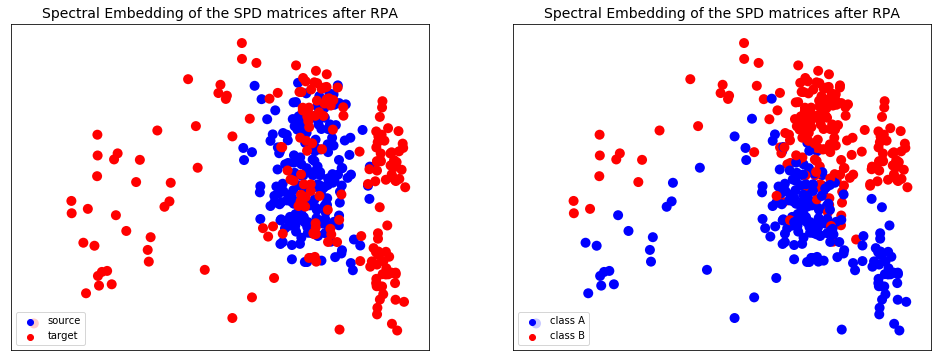

In [9]:
# plot the scatter plot for the spectral embedding
fig, ax = plt.subplots(facecolor='white', figsize=(16.5,6), ncols=2)
colors = {1:'b', 2:'r', 3:'g'}

for ui, si in zip(urot, sess):
    ax[0].scatter(ui[1], ui[2], s=100, facecolor=colors[si], edgecolor='none')
ax[0].set_title('Spectral Embedding of the SPD matrices after RPA', fontsize=14)   
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].scatter([], [], facecolor=colors[1], label='source')
ax[0].scatter([], [], facecolor=colors[2], label='target')
ax[0].legend(loc='lower left')

for ui, yi in zip(urot, labs):
    ax[1].scatter(ui[1], ui[2], s=100, facecolor=colors[yi], edgecolor='none')
ax[1].set_title('Spectral Embedding of the SPD matrices after RPA', fontsize=14)   
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].scatter([], [], facecolor=colors[1], label='class A')
ax[1].scatter([], [], facecolor=colors[2], label='class B')
ax[1].legend(loc='lower left')

We observe now a different pattern on the spectral embedding. The separation we had between data points from the *source* and *target* datasets is no longer so evident in the left plot. On the other hand, the separation of classes is very good on the right plot and implies that a classifier trained on the *source* dataset will have good performance to infer labels of the *target* dataset.